In [1]:
!pip install xlrd==2.0.0
# !pip install https://github.com/explosion/spacy-models/releases/download/de_core_news_lg-3.3.0/de_core_news_lg-3.3.0.tar.gz
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 95 kB 2.5 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import spacy
from tqdm import tqdm
import re
import pickle
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
commentsDF = pd.DataFrame(columns={'ID'})
for file in glob.glob("/content/drive/MyDrive/MA/Daten/*"):
     tempDF = pd.read_excel(file)
     commentsDF = pd.concat([commentsDF, tempDF], join='outer')

commentsDF = commentsDF.drop(columns=['ID', 'Active', 'CID', 'Sperrhinweis'],axis=1)

commentsDF['Date'] =  pd.to_datetime(commentsDF['Date'], format='%Y-%m-%d %H:%M:%S')
commentsDF['Time'] = pd.to_datetime(commentsDF['Date']).dt.time
commentsDF['Date'] = pd.to_datetime(commentsDF['Date']).dt.date
commentsDF['Date'] = pd.to_datetime(commentsDF['Date'], format='%Y-%m-%d')

commentsDF['Text'] = commentsDF['Text'].astype(str)
commentsDF['Title'] = commentsDF['Title'].astype(str)

commentsDF = commentsDF.drop_duplicates(subset=['Text']) 
commentsDF = commentsDF.sort_values(by=['Date']).reset_index(drop=True)

In [ ]:
saveDF = commentsDF
# commentsDF = saveDF

In [ ]:
monthDF = commentsDF.groupby(pd.Grouper(key='Date', freq='M')).count()
saveDF.index

RangeIndex(start=0, stop=254257, step=1)

In [ ]:
# commentsDF['Title'] = commentsDF['Title'].apply(lambda x: x[13:])

# # split dataset into 2 month intervals
batch1 = (commentsDF.Date < "2019-01-01")
batch2 = (commentsDF.Date >= "2019-01-01") & (commentsDF.Date < "2019-03-01")
batch3 = (commentsDF.Date >= "2019-03-01") & (commentsDF.Date < "2019-05-01") 
batch4 = (commentsDF.Date >= "2019-05-01") & (commentsDF.Date < "2019-07-01") 
batch5 = (commentsDF.Date >= "2019-07-01") & (commentsDF.Date < "2019-09-01") 
batch6 = (commentsDF.Date >= "2019-09-01") & (commentsDF.Date < "2019-11-01") 
batch7 = (commentsDF.Date >= "2019-11-01") & (commentsDF.Date < "2020-01-01") 
batch8 = (commentsDF.Date >= "2020-01-01") & (commentsDF.Date < "2020-03-01") 
batch9 = (commentsDF.Date >= "2020-03-01") & (commentsDF.Date < "2020-05-01") 
batch10 = (commentsDF.Date >= "2020-05-01") & (commentsDF.Date < "2020-07-01") 

# split dataset into 2 month intervals
# batch1 = (commentsDF.Date < "2019-01-01") & (commentsDF.Abgelehnt == 1)
# batch2 = (commentsDF.Date >= "2019-01-01") & (commentsDF.Date < "2019-03-01") & (commentsDF.Abgelehnt == 1)
# batch3 = (commentsDF.Date >= "2019-03-01") & (commentsDF.Date < "2019-05-01") & (commentsDF.Abgelehnt == 1)
# batch4 = (commentsDF.Date >= "2019-05-01") & (commentsDF.Date < "2019-07-01")  & (commentsDF.Abgelehnt == 1)
# batch5 = (commentsDF.Date >= "2019-07-01") & (commentsDF.Date < "2019-09-01")  & (commentsDF.Abgelehnt == 1)
# batch6 = (commentsDF.Date >= "2019-09-01") & (commentsDF.Date < "2019-11-01")  & (commentsDF.Abgelehnt == 1)
# batch7 = (commentsDF.Date >= "2019-11-01") & (commentsDF.Date < "2020-01-01")  & (commentsDF.Abgelehnt == 1)
# batch8 = (commentsDF.Date >= "2020-01-01") & (commentsDF.Date < "2020-03-01")  & (commentsDF.Abgelehnt == 1)
# batch9 = (commentsDF.Date >= "2020-03-01") & (commentsDF.Date < "2020-05-01")  & (commentsDF.Abgelehnt == 1)
# batch10 = (commentsDF.Date >= "2020-05-01") & (commentsDF.Date < "2020-07-01") & (commentsDF.Abgelehnt == 1)

In [4]:
german_stop_words_import = open ("/content/drive/MyDrive/MA/stopwords-de.csv", "r", encoding="utf-8")
german_stop_words = pd.read_csv(german_stop_words_import, names=['stopwords'])['stopwords'].to_list()
print(len(german_stop_words))

619


In [5]:
# nltk.download("stopwords")

# stopwords source: https://github.com/stopwords-iso/stopwords-de
german_stop_words_import = open ("/content/drive/MyDrive/MA/stopwords-de.csv", "r", encoding="utf-8")
german_stop_words = pd.read_csv(german_stop_words_import, names=['stopwords'])['stopwords'].to_list()


tf = TfidfVectorizer(stop_words=german_stop_words, min_df = 5, ngram_range=(1,2), max_features=3224)
tfidf_pickle = open ("/content/drive/MyDrive/MA/preprocessor_RP_Comments_noDupes.pk", "rb")
tfidf_load = pickle.load(tfidf_pickle)
tfidf_noDup_dat = tf.fit_transform(tfidf_load).toarray()


In [6]:
# creates Sampled down version of dataset

dateRange = pd.period_range(start='2018-11-01', end='2020-06-01', freq='M')
timeSampledDF = pd.DataFrame(columns={'ID'})


for i in range(len(dateRange)):
  month = dateRange[i].month
  year = dateRange[i].year
  monthData = commentsDF[(commentsDF.Date.dt.month == dateRange[i].month) & (commentsDF.Date.dt.year == dateRange[i].year)]
  countMinor = len(monthData[monthData.Abgelehnt == 1])
  if countMinor < 600:
    countMinor = 600
  minorityDF = monthData[monthData.Abgelehnt == 1]
  majorityDF = monthData[monthData.Abgelehnt == 0].sample(axis='index', 
                                                          n=countMinor, 
                                                          random_state=4711,)
  timeSampledDF = pd.concat([timeSampledDF, majorityDF], join='outer')
  timeSampledDF = pd.concat([timeSampledDF, minorityDF], join='outer')

y_vals = commentsDF['Abgelehnt'].values
y_vals = y_vals.astype(int)


commentsDF['index1'] = commentsDF.index
timeSampledDF['index1'] = timeSampledDF.index
timeSampledDF.sort_values(by='Date',inplace=True)


commentsDF['Mask'] = commentsDF.index1.apply(lambda x: 1 if x in timeSampledDF.index1 else 0)
mask = np.array(commentsDF['Mask']).astype('bool')


In [ ]:
mask1 = np.array(batch1, dtype= bool)
mask2 = np.array(batch2, dtype= bool)
mask3 = np.array(batch3, dtype= bool)
mask4 = np.array(batch4, dtype= bool)
mask5 = np.array(batch5, dtype= bool)
mask6 = np.array(batch6, dtype= bool)
mask7 = np.array(batch7, dtype= bool)
mask8 = np.array(batch8, dtype= bool)
mask9 = np.array(batch9, dtype= bool)
mask10 = np.array(batch10, dtype= bool)


In [ ]:
tokenizedFrame = pd.DataFrame(tfidf_load, columns=['Text'])
tokenizedFrame['Text'] = tokenizedFrame['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (german_stop_words)]))

In [ ]:
def getTopWords(n, mask):
  lst = tokenizedFrame['Text'][mask].to_list()
  textBatch = [word for item in lst for word in item.split()]
  counter = Counter(textBatch)
  # return(counter.most_common(n)
  return counter



# topWordDF = pd.DataFrame()
# topWordDF['Top Words Batch 1'] = getTopWords(20, mask1)
# topWordDF['Top Words Batch 2'] = getTopWords(20, mask2)
# topWordDF['Top Words Batch 3'] = getTopWords(20, mask3)
# topWordDF['Top Words Batch 4'] = getTopWords(20, mask4)
# topWordDF['Top Words Batch 5'] = getTopWords(20, mask5)
# topWordDF['Top Words Batch 6'] = getTopWords(20, mask6)
# topWordDF['Top Words Batch 7'] = getTopWords(20, mask7)
# topWordDF['Top Words Batch 8'] = getTopWords(20, mask8)
# topWordDF['Top Words Batch 9'] = getTopWords(20, mask9)
# topWordDF['Top Words Batch 10'] = getTopWords(20, mask10)


In [ ]:
temp = getTopWords(1, mask2)
print(temp)

Counter({'geben': 4926, 'Jahr': 3728, 'Mensch': 3007, 'sehen': 2774, 'Deutschland': 2761, 'einfach': 2264, 'Herr': 2185, 'vieler': 2133, 'Land': 2061, 'deutsch': 2027, 'sagen': 1987, 'Frau': 1929, 'Afd': 1889, 'neu': 1857, 'stehen': 1761, 'lassen': 1741, '--': 1701, 'Zeit': 1662, 'eigentlich': 1621, 'finden': 1572, 'Problem': 1476, 'bleiben': 1468, 'Stadt': 1459, 'Geld': 1439, 'Bürger': 1426, 'halten': 1410, 'Politik': 1366, 'stellen': 1321, 'Partei': 1286, 'Politiker': 1278, 'Kind': 1271, 'sicher': 1251, 'nehmen': 1229, 'fahren': 1224, 'denken': 1212, 'Artikel': 1178, 'brauchen': 1166, 'klar': 1146, 'genau': 1136, 'Leute': 1125, 'bekommen': 1109, 'Frage': 1105, 'alt': 1098, 'liegen': 1089, 'EU': 1080, 'leider': 1077, 'lesen': 1075, 'verstehen': 1059, 'letzter': 1058, 'Tag': 1051, 'SPD': 1046, 'zeigen': 1044, 'Welt': 1043, 'glauben': 1025, 'schön': 1013, 'bringen': 1011, 'Staat': 991, 'bitte': 987, 'politisch': 984, 'Mann': 974, 'klein': 962, 'Thema': 959, 'Auto': 955, 'Fall': 946, 'Ko

In [ ]:
# vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=3)
# def getWordCount(mask):
#   # returns dataframe with unique words in corp
#   feature_count = vectorizer.fit_transform(commentsDF['Text'][mask])  # Fit count vectorizer
#   features = vectorizer.get_feature_names()  # get unique words in corpa
#   return pd.DataFrame(feature_count.toarray(), columns=features, index=commentsDF['Text'][mask].index)

def getTopWords(mask):
  lst = tokenizedFrame['Text'][mask].to_list()
  textBatch = [word for item in lst for word in item.split()]
  counter = Counter(textBatch)
  # return(counter.most_common(n)
  return dict(counter)

def filterDict(inputDict, lowestValue):
  filteredDict = dict()
  # Iterate over all the items in dictionary and filter items which are lower than the given value
  for (key, value) in inputDict.items():
   if int(value) >= lowestValue:
       filteredDict[key] = value
  return(filteredDict)

def getDifferentWords(dict1, dict2):
  difference = { k : dict2[k] for k in set(dict2) - set(dict1) }
  return(Counter(difference))

def compareDicts(mask1, mask2, lowestValue) :
  difference = getDifferentWords(filterDict(getTopWords(mask1),lowestValue),filterDict(getTopWords(mask2),lowestValue))
  return difference.most_common(15)

In [ ]:
resultFrame = pd.DataFrame()
resultFrame['1'] = compareDicts(mask1, mask2, 5)
resultFrame['2'] = compareDicts(mask2, mask3, 5)
resultFrame['3'] = compareDicts(mask3, mask4, 5)
resultFrame['4'] = compareDicts(mask4, mask5, 5)
resultFrame['5'] = compareDicts(mask5, mask6, 5)
resultFrame['6'] = compareDicts(mask6, mask7, 5)
resultFrame['7'] = compareDicts(mask7, mask8, 5)
resultFrame['8'] = compareDicts(mask8, mask9, 5)
resultFrame['9'] = compareDicts(mask9, mask10, 5)

resultFrame

resultFrame.to_excel('emergingWords.xlsx')

In [ ]:
resultFrame

,1,2,3,4,5,6,7,8,9
0,"(Magnitz, 112)","(future, 97)","(Rezo, 459)","(Tönnies, 475)","(Wolfsberg, 73)","(Umweltsau, 76)","(Kemmerich, 200)","(Risikogruppe, 295)","(Tönnies, 335)"
1,"(Oper, 102)","(Notre, 85)","(strach, 187)","(Linnemann, 114)","(Klimapaket, 70)","(Judaslohn, 58)","(Rösler, 156)","(Ausgangssperre, 231)","(Gütersloh, 86)"
2,"(Stelter, 94)","(Palmer, 77)","(fpö, 182)","(Abrainyactress, 90)","(Geländewag, 65)","(Esk, 51)","(Hanau, 118)","(Maskenpflicht, 227)","(Fleischindustrie, 70)"
3,"(Maduro, 86)","(Friday, 72)","(embolo, 107)","(University, 89)","(Grönemeyer, 51)","(Weeze, 50)","(Stieler, 96)","(Klopapier, 224)","(Floyd, 66)"
4,"(knobloch, 84)","(Tilly, 68)","(Lübcke, 107)","(Sarr, 87)","(Karaman, 50)","(Heilpraktiker, 49)","(Tilly, 87)","(Jorgemario, 154)","(Amthor, 56)"
5,"(Prüffall, 70)","(Grindel, 68)","(Nationalhymne, 74)","(Vdl, 68)","(deg, 47)","(Buhrow, 44)","(röttgen, 87)","(Großveranstaltung, 134)","(George, 54)"
6,"(Doppelnam, 58)","(Karfreitag, 64)","(Kapitänin, 69)","(Warheit, 61)","(Metzelder, 46)","(Bon, 44)","(Coronavirus, 69)","(Lockerung, 123)","(farbig, 52)"
7,"(Handball, 55)","(Christchurch, 57)","(österreichisch, 67)","(Steamer, 56)","(Cook, 46)","(Miri, 40)","(Corona, 69)","(Virolog, 116)","(Randalierer, 50)"
8,"(Keltek, 53)","(Methan, 56)","(Hymne, 66)","(Restle, 53)","(özdemir, 45)","(Gemeinnützigkeit, 39)","(Soleimani, 65)","(snoopy, 110)","(sub, 49)"
9,"(bm, 52)","(Sri, 54)","(Fpö, 58)","(Bensebaini, 51)","(Rebellion, 43)","(qr, 36)","(Nachfolgepartei, 61)","(Toilettenpapier, 109)","(taz, 44)"


In [ ]:
# commList = commentsDF['Title'].unique().tolist()
# checkList = saveDF['Title'].unique().tolist()

# list(set(checkList) - set(commList))

In [ ]:
commentsDF['Title'] = commentsDF['Title'].apply(lambda x: x[13:])
print(commentsDF.Title)

0                                     Merz tut dem Land gut
1                                   Lächeln im hohen Norden
2          Österreich zieht sich aus UN-Migrationspakt z...
3          Banden betrügen Staat bei Hartz IV um 50 Mill...
4          Banden betrügen Staat bei Hartz IV um 50 Mill...
                                ...                        
254252     Klingbeil hält Laschet für nicht kanzlertaug...
254253            Alles auf Anfang im Düsseldorfer Rheinbad
254254     Nicht-weiße Simpsons-Figuren sollen neue St...
254255            Streiks bei Amazon in Rheinberg und Werne
254256     Viele Menschen wissen gar nicht, was wirklic...
Name: Title, Length: 254257, dtype: object


In [ ]:
def transform(textSeries):
  documents = []
  nlp = spacy.load("de_core_news_lg")
  for sen in tqdm(range(0, len(textSeries))):
    # Tweet Dataset specific operations:
    # Removing mentions ("@name") because theyre anonymous irregularly
    document = re.sub(r'@\w+', ' ', str(textSeries[sen]))

    # Removing "http://" which indicates a link
    document = re.sub(r'\bhttp://',' ', document)

    # Removing "www." which indicates a link
    document = re.sub(r'\bwww.',' ', document)

    # Remove all the special characters
    document = re.sub(r'\W', ' ', document)

    # Remove numbers
    document = re.sub(r'[0-9]', ' ', document)

    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)

    # Converting to Lowercase
    document = document.lower()

    # Lemmatization
    document = nlp(document)
 
    document = [word.lemma_ for word in document]
    document = ' '.join(document)
        
    documents.append(document)

  return documents

In [ ]:
groupedAbgelehnt = commentsDF.groupby(by=['Loginname'])['Abgelehnt'].sum()
abgUserDistribution = groupedAbgelehnt.sort_values(ascending = False)

In [ ]:
abgUserDistribution

Loginname
edomsgen@web.de      227.0
HoBre                221.0
Winterwind           217.0
Erwin Eintopf        206.0
f.schagen@gmx.de     172.0
                     ...  
Un-Gerechtigtkeit      0.0
Umachon@aol.com        0.0
UlrikePaschkowski      0.0
Ulrike123456           0.0
40237                  0.0
Name: Abgelehnt, Length: 10938, dtype: float64

In [ ]:
abgelehntList = abgUserDistribution.values.tolist()

noRemovals = abgelehntList.count(0)
oneRemoval = abgelehntList.count(1)
totalUsers = len(abgelehntList)

# 5% User: 547
print("The top 5% percent of Users, when sorted by deleted comments, are responsible for ", 
      round((sum(abgelehntList[:547])/sum(abgelehntList))*100,2), "% of deleted comments.\n")

print("The top 10% percent of Users, when sorted by deleted comments, are responsible for ", 
      round((sum(abgelehntList[:1094])/sum(abgelehntList))*100,2), "% of deleted comments.\n")


print("The top 25% percent of Users, when sorted by deleted comments, are responsible for ", 
      round((sum(abgelehntList[:2735])/sum(abgelehntList))*100,2), "% of deleted comments.\n")

print("The top 50% percent of Users, when sorted by deleted comments, are responsible for ", 
      round((sum(abgelehntList[:5470])/sum(abgelehntList))*100,2), "% of deleted comments.\n")

print("In total Users are responsible for ", 
      sum(abgelehntList), "deleted comments.\n")

print(noRemovals, "Users did not post a comment that got removed and make up ", 
      round((noRemovals/totalUsers)*100,2), "% of users.\n")

print(oneRemoval, "Users got one of their comments removed and make up",
      round((oneRemoval/totalUsers)*100,2), "% of users. \n")

print("Total Users:",len(abgelehntList))

The top 5% percent of Users, when sorted by deleted comments, are responsible for  82.38 % of deleted comments.

The top 10% percent of Users, when sorted by deleted comments, are responsible for  92.19 % of deleted comments.

The top 25% percent of Users, when sorted by deleted comments, are responsible for  100.0 % of deleted comments.

The top 50% percent of Users, when sorted by deleted comments, are responsible for  100.0 % of deleted comments.

In total Users are responsible for  16143.0 deleted comments.

8634 Users did not post a comment that got removed and make up  78.94 % of users.

1159 Users got one of their comments removed and make up 10.6 % of users. 

Total Users: 10938


In [ ]:
for i in range(1000,5100):
  if sum(abgelehntList[:i]) == 16298:
    print(i)


In [ ]:
print(sum(abgelehntList[:547]), sum(abgelehntList[:1094]), sum(abgelehntList[:2735]), sum(abgelehntList))

13298.0 14882.0 16143.0 16143.0


(array([311., 107.,  69.,  48.,  44.,  26.,  20.,  26.,  20.,   9.,  15.,
          6.,  17.,  10.,   8.,   7.,   8.,   8.,   9.,   3.,   5.,   4.,
          5.,   2.,   5.,   1.,   1.,   1.,   6.,   0.,   1.,   5.,   2.,
          1.,   1.,   3.,   2.,   1.,   1.,   2.,   1.,   1.,   0.,   0.,
          1.,   3.,   0.,   1.,   0.,   0.,   1.,   0.,   2.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,
          1.]),
 array([  3.  ,   5.24,   7.48,   9.72,  11.96,  14.2 ,  16.44,  18.68,
         20.92,  23.16,  25.4 ,  27.64,  29.88,  32.12,  34.36,  36.6 ,
         38.84,  41.08,  43.32,  45.56,  47.8 ,  50.04,  52.28,  54.52,
         56.76,  59.  ,  61.24,  63.48,  65.72,  67.96,  70.2 ,  72.44,
         74.68,  76.92,  79.16

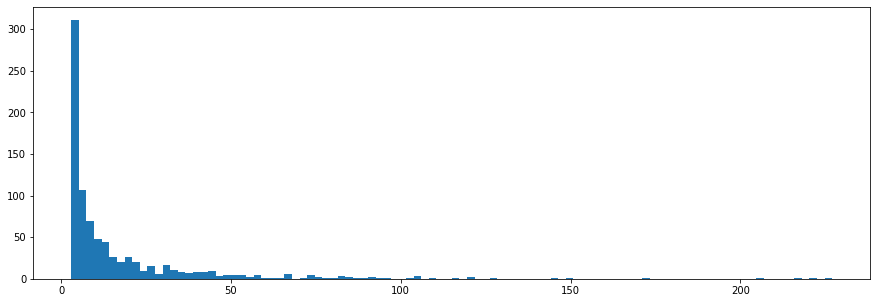

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.hist([x for x in abgelehntList if x > 2], bins = 100)

# Wordclouds aus Titeln der Artikel

Zunächst für alle Artikel und dann für Artikel mit abgelehnten Kommentaren.

In [ ]:
lemmaDF = commentsDF
lemmaDF['Title'] = transform(lemmaDF['Title'])

OSError: ignored

In [ ]:
lemmaDF.to_pickle('lemmatizedTitle.pkl')

In [ ]:
# Import the wordcloud library
nltk.download('stopwords')
german_stop_words = stopwords.words('german')

lemmaDF['Title'] = lemmaDF['Title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (german_stop_words)]))

# Join the different processed titles together.
long_string = ','.join(list(lemmaDF['Title'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3,
                      width=800, height=500,contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

##Wordcloud Denied Comments

In [ ]:
lemmaDF = commentsDF
lemmaDF['Text'] = tfidf_load

In [ ]:
lemmaAbgelehntDF = lemmaDF[lemmaDF.Abgelehnt == 1]

In [ ]:
# stopwords source: https://github.com/stopwords-iso/stopwords-de
german_stop_words_import = open ("/content/drive/MyDrive/MA/stopwords-de.csv", "r", encoding="utf-8")
german_stop_words = pd.read_csv(german_stop_words_import, names=['stopwords'])['stopwords'].to_list()

# import list of German verbs from:
# https://github.com/viorelsfetea/german-verbs-database
verbsDF = pd.read_csv("/content/drive/MyDrive/MA/verbs.csv")
german_stop_words.extend(verbsDF['Infinitive'].to_list())
german_stop_words.extend(['ja', 'schon', 'mehr', 'wer', 'mal', 'gut','vieler',
                          'immer', 'einfach'])

lemmaAbgelehntDF['Text'] = lemmaAbgelehntDF['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (german_stop_words)]))

# wordcloud for first half of dataset
# firstHalf = lemmaAbgelehntDF.Date <= '15-07-2019'

# Join the different processed titles together.
long_string = ','.join(list(lemmaAbgelehntDF['Text'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3,
                      width=800, height=500,contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()


In [ ]:
# secondHalf = lemmaAbgelehntDF.Date > '31-12-2019'


# long_stringSecond = ','.join(list(lemmaAbgelehntDF['Text'][secondHalf].values))

# # Create a WordCloud object
# wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3,
#                       width=800, height=500,contour_color='steelblue')
# # Generate a word cloud
# wordcloud.generate(long_stringSecond)
# # Visualize the word cloud
# wordcloud.to_image()

In [ ]:
lemmaAbgelehntDF['Text'].dropna()

# Exploration of Data Distribution

Analysis of ratio of accepted to denied comments in non- and sampled dataset.

Distribution Full Dataset

In [ ]:
commentsDF['Akzeptiert'] = (commentsDF.Abgelehnt - 1)*-1
abuseDist = commentsDF.groupby(['Date'])['Abgelehnt','Akzeptiert'].sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


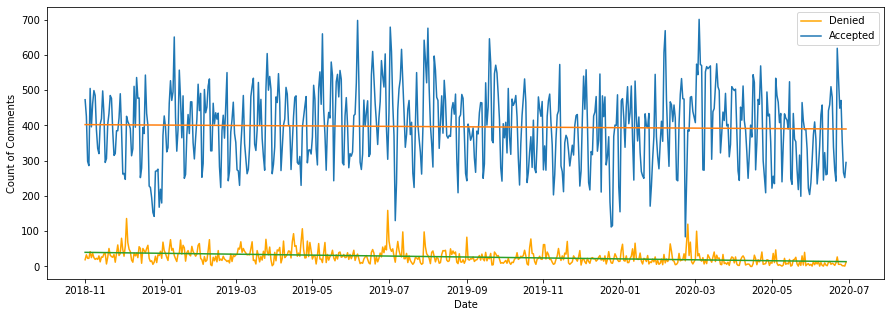

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))


ax.plot(abuseDist.index, abuseDist.Abgelehnt, label='Denied',color='orange')
ax.plot(abuseDist.index, abuseDist.Akzeptiert, label='Accepted')
ax.set_xlabel('Date')
ax.set_ylabel('Count of Comments')


# # trendline 

# #calculate equation for trendline --> accepted comments
z = np.polyfit(dates.date2num(abuseDist.index), abuseDist.Akzeptiert, 1)
p = np.poly1d(z)

# #calculate equation for trendline --> denied comments
z1 = np.polyfit(dates.date2num(abuseDist.index), abuseDist.Abgelehnt, 1)
p1 = np.poly1d(z1)

# #add trendlines to plot
ax.plot(dates.date2num(abuseDist.index), p(dates.date2num(abuseDist.index)))
ax.plot(dates.date2num(abuseDist.index), p1(dates.date2num(abuseDist.index)))

ax.legend()
plt.savefig('Distribution of Accepted and Denied Comments - with Trendline.png')

Distribution Sampled Dataset

In [7]:
timeSampledDF['Akzeptiert'] = (timeSampledDF.Abgelehnt - 1)*-1
abuseDist = timeSampledDF.groupby(['Date'])['Abgelehnt','Akzeptiert'].sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


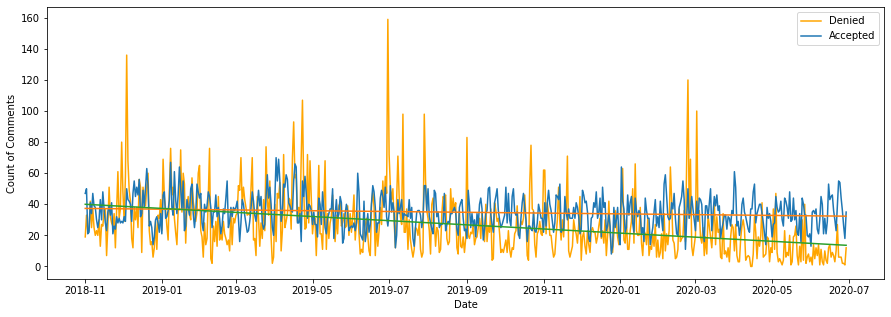

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))


ax.plot(abuseDist.index, abuseDist.Abgelehnt, label='Denied',color='orange')
ax.plot(abuseDist.index, abuseDist.Akzeptiert, label='Accepted')
ax.set_xlabel('Date')
ax.set_ylabel('Count of Comments')


# # trendline 

# #calculate equation for trendline --> accepted comments
z = np.polyfit(dates.date2num(abuseDist.index), abuseDist.Akzeptiert, 1)
p = np.poly1d(z)

# #calculate equation for trendline --> denied comments
z1 = np.polyfit(dates.date2num(abuseDist.index), abuseDist.Abgelehnt, 1)
p1 = np.poly1d(z1)

# #add trendlines to plot
ax.plot(dates.date2num(abuseDist.index), p(dates.date2num(abuseDist.index)))
ax.plot(dates.date2num(abuseDist.index), p1(dates.date2num(abuseDist.index)))

ax.legend()
plt.savefig('Distribution of Accepted and Denied Comments - with Trendline.png')

In [8]:
monthDF = timeSampledDF.groupby(pd.Grouper(key='Date', freq='M')).sum()
monthDF = monthDF.reset_index()
monthDF['Date'] = monthDF['Date'].apply(lambda x: x.strftime('%Y-%m'))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text major ticklabel objects>)

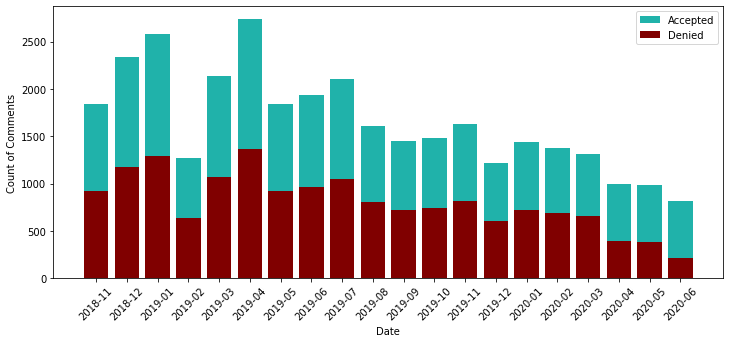

In [9]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.bar(monthDF.Date, monthDF.Akzeptiert, label='Accepted',bottom=monthDF.Abgelehnt, color='lightseagreen')
ax.bar(monthDF.Date, monthDF.Abgelehnt, label='Denied', color='maroon')

ax.set_xlabel('Date')
ax.set_ylabel('Count of Comments')
ax.legend()

plt.xticks(rotation=45)


In [11]:
print(timeSampledDF.Abgelehnt.sum(), timeSampledDF.Akzeptiert.sum())

16143.0 16952.0


In [ ]:
trainrange = timeSampledDF.Date < "2019-11-01"

In [ ]:
timeSampledDF[trainrange].describe()

,Abgelehnt,index1,Akzeptiert
count,24616.000000,24616.000000,24616.000000
mean,0.473919,74832.085229,0.526081
std,0.499329,45194.178725,0.499329
min,0.000000,4.000000,-0.000000
25%,0.000000,34832.250000,-0.000000
50%,0.000000,71309.500000,1.000000
75%,1.000000,112481.250000,1.000000
max,1.000000,158666.000000,1.000000


<BarContainer object of 2 artists>

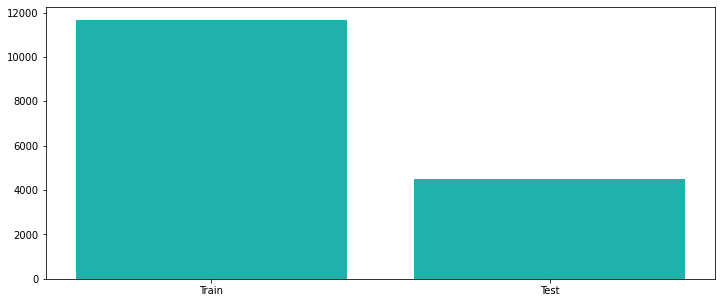

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.bar(x, y2, label='Accepted', color='lightseagreen')

In [ ]:
y1 = [timeSampledDF[trainrange].Akzeptiert.sum(), timeSampledDF[~trainrange].Akzeptiert.sum()]
y2 = [timeSampledDF[trainrange].Abgelehnt.sum(), timeSampledDF[~trainrange].Abgelehnt.sum()]
x = ['Train', 'Test']

<BarContainer object of 2 artists>

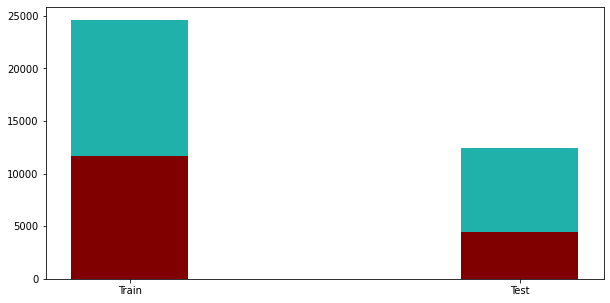

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(x, y1, label='Accepted', color='lightseagreen', bottom=y2, width=0.3)
ax.bar(x, y2, label='Rejected', color='maroon', width=0.3)